In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from matplotlib import cm
from root_pandas import read_root
import scipy.stats
import scipy.ndimage
from matplotlib import gridspec
import matplotlib.lines as mlines
import ROOT
import scipy.stats
from matplotlib import gridspec
import matplotlib.lines as mlines
from scipy.stats import chi2
from scipy import interpolate
import pandas as pd
import math

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

def getArrays(tree):

    chi2_c = np.zeros(tree.GetEntries())
    dm2_c = np.zeros(tree.GetEntries())
    sin22th_c = np.zeros(tree.GetEntries())
    
    for j in range(tree.GetEntries()):
        tree.GetEntry(j)
        
        chi2_c[j] = tree.chi2
        dm2_c[j] = tree.dm2
        sin22th_c[j] = tree.sin22th
        
    chi2 = chi2_c[chi2_c>0]
    dm2 = dm2_c[chi2_c>0]
    sin22th = sin22th_c[chi2_c>0]
    return chi2, dm2, sin22th

def getContour(sin22th,dm2):

    adm2 = np.asarray(dm2)
    asin22th = np.asarray(sin22th)

    cosin22th = np.zeros(len(np.unique(adm2)))
    codm2 = np.zeros(len(np.unique(adm2)))

    for i in range(len(np.unique(adm2))):
        indy = np.argmin(asin22th[adm2==adm2[i]])
        cosin22th[i] = asin22th[adm2==np.unique(adm2)[i]][indy]
        codm2[i] = np.unique(adm2)[i]    
    return cosin22th, codm2

def getContourt(tree):

    dm2 = np.zeros(tree.GetEntries())
    sin22th = np.zeros(tree.GetEntries())
    
    for j in range(tree.GetEntries()):
        tree.GetEntry(j)
        
        dm2[j] = tree.dm2
        sin22th[j] = tree.sin22th
    
    adm2 = np.asarray(dm2)
    asin22th = np.asarray(sin22th)


    cosin22th = np.zeros(len(np.unique(adm2)))
    codm2 = np.zeros(len(np.unique(adm2)))

    for i in range(len(np.unique(adm2))):
        indy = np.argmin(asin22th[adm2==adm2[i]])
        cosin22th[i] = asin22th[adm2==np.unique(adm2)[i]][indy]
        codm2[i] = np.unique(adm2)[i]    
    
    return cosin22th, codm2

def calcChi2Simple(exp,obs):
    chi2tot = 0
    for idx in range(obs.shape[0]):
        if exp[idx] !=0:
            chi2tot += ((obs[idx]-exp[idx])*(obs[idx]-exp[idx]))/exp[idx]
    return chi2tot

def getBinCL(vals,bins,cl):
    sum = 0
    tot = np.sum(vals)
    for idx in range(len(bins)):
        sum += vals[idx]
        if sum > cl*tot:
            return bins[idx]
    assert 1==2

Welcome to JupyROOT 6.16/00


Get values from text files which have the frquentist study results

In [2]:
do1x = True
statsOnly = False
confidence_limit = 0.9

In [3]:
# we're going to load in two arrays
with open("bins.txt","r") as bins:
    lines = bins.readlines()
    lines[0].strip()
    lines[1].strip()
    vals0 = lines[0].split(" ")
    vals1 = lines[1].split(" ")
    m41_list= []
    sin22theta_list= []
    for v in range(len(vals0)-1):
        m41_list.append(float(vals0[v]))
    for v in range(len(vals1)-1):
        sin22theta_list.append(float(vals1[v]))
print("m values:", m41_list )
print(len(m41_list))
print("sin2 values:",sin22theta_list)

m values: [0.01, 0.0144544, 0.020893, 0.0301995, 0.0436516, 0.0630957, 0.0912011, 0.131826, 0.190546, 0.275423, 0.398107, 0.57544, 0.831764, 1.20226, 1.7378, 2.51189, 3.63078, 5.24807, 7.58578, 10.9648, 15.8489, 22.9087, 33.1131, 47.863, 69.1831, 100.0]
26
sin2 values: [0.01, 0.0120226, 0.0144544, 0.017378, 0.020893, 0.0251189, 0.0301995, 0.0363078, 0.0436516, 0.0524807, 0.0630957, 0.0758578, 0.0912011, 0.109648, 0.131826, 0.158489, 0.190546, 0.229087, 0.275423, 0.331131, 0.398107, 0.47863, 0.57544, 0.691831, 0.831764, 1.0]


In [4]:
# chi2 array is more complicated
# each row represents a grid point
# first load as list of lists and make 1D plots

# number of universes used in this simulation
num_uni=1000
# initialize arr to fill
chi2_manyuni_arr=[]
chisFile= ""
if statsOnly:
    chisFile = "rterms_statsonly_1x_full_1000.txt"
else:
    chisFile = "rterms_1x_full_shaperate_1000.txt"
# with open(chisFile,"r") as chis:
#     lines = chis.readlines()
#     for line in lines:
#         vals = line.split(" ")
#         chi2list = []
#         for v in range(len(vals)-1):
#             chi2list.append(float(vals[v]))
#         chi2_manyuni_arr.append(chi2list)
        
# Write Fix Hack:        
with open(chisFile,"r") as chis:
    lines = chis.readlines()
    for line in lines:
        vals = line.split(" ")
        chi2list = []
        for v in range(len(vals)-1):
            chi2list.append(float(vals[v]))
            if len(chi2list) == num_uni:
                chi2_manyuni_arr.append(chi2list)
                chi2list = []
        

print("size check of text files")
print(len(chi2_manyuni_arr),(len(m41_list)-1)*(len(sin22theta_list)-1))
print(num_uni,len(chi2_manyuni_arr[-1]))
        

size check of text files
625 625
1000 1000


m 15 s 24
2.51189 0.831764

2 12342.645241687092

Min: 0.0
Best R, nDoF: 12342.645241687092 2


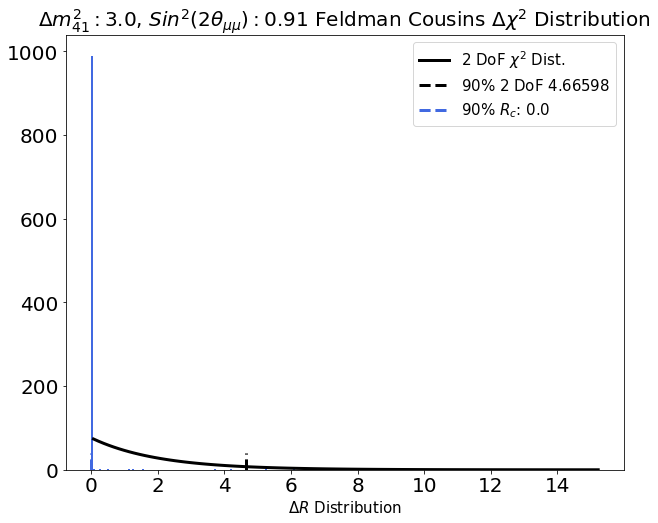

In [20]:
pt = 0
linewidth = 3
# pt = 12*25+20 #m*25+s
pt = 399
# pt = 5
m_id = math.floor(pt/(len(m41_list)-1)) #15
s_id = pt % (len(sin22theta_list)-1) #24
chi2_manyuni_arr[pt].sort()
val_90th =chi2_manyuni_arr[pt][math.floor(num_uni*confidence_limit)]
print("m",m_id,"s",s_id)
print(m41_list[m_id], sin22theta_list[s_id])
val_99th =chi2_manyuni_arr[pt][math.floor(num_uni*.99)]
fig,ax = plt.subplots(figsize=(10,8))
vls,hbins,_=plt.hist(chi2_manyuni_arr[pt],bins=100,color='royalblue')
plt.title('m41: '+ str(m41_list[m_id])+' sin2: '+str(sin22theta_list[s_id]))
plt.title(r'Null-Disappearance Feldman Cousins $R$ Distribution',fontsize=20)
plt.title(r'$\Delta m_{41}^2: 3.0$, $Sin^2(2\theta_{\mu\mu}): 0.91$ Feldman Cousins $\Delta\chi^2$ Distribution',fontsize=20)
plot90, = plt.plot([val_90th,val_90th],[0,40],color='royalblue',linestyle='dashed',linewidth=linewidth,label=r'$90\%$ $R_c$: '+str(val_90th))
# plot99, = plt.plot([val_99th,val_99th],[0,40],color='magenta',label=r'$99\%$ $\chi^2_c$: '+str(val_99th))
clr = ['gray','black','orange','green','purple','blue','brown','plum','tan','darkorchid','salmon','powderblue']
# ndf_x = [(hbins[i]+hbins[i+1])/2 for i in range(hbins.shape[0]-1)]
bestfit_ndof = -1
bestfit_chi  = 10e+999
print()
plots = []
for df in range(2,3):
    ndf_chidist = chi2.pdf(ndf_x, df=df)
    ndf_chidist = (1000./np.sum(ndf_chidist))*ndf_chidist
    bin90 = getBinCL(ndf_chidist,ndf_x,confidence_limit)
    thisPlot,   = plt.plot(ndf_x, ndf_chidist,linewidth=linewidth,color=clr[(df-1)%len(clr)],label=str(df)+' DoF '+r'$\chi^2$ Dist.')
    thisplot90, = plt.plot([bin90,bin90],[0,40],linewidth=linewidth,linestyle='dashed',color=clr[(df-1)%len(clr)],label=r'$90\%$ '+str(df)+' DoF '+str(round(bin90,5)))
    plots.append(thisPlot)
    plots.append(thisplot90)
    thischi = calcChi2Simple(ndf_chidist,vls)
    print(df,thischi)
    if thischi < bestfit_chi:
        bestfit_chi = thischi
        bestfit_ndof = df
print()
print("Min:",np.min(chi2_manyuni_arr[pt]))
# print("Best Chi, nDoF:",bestfit_chi, bestfit_ndof)
print("Best R, nDoF:",bestfit_chi, bestfit_ndof)

# plt.xlabel(r'$\Delta\chi^2$ Distribution',fontsize=15)
plt.xlabel(r'$\Delta R$ Distribution',fontsize=15)

plots.append(plot90)
# plots.append(plot99)
# plt.legend()
ax.legend(handles=plots,fontsize=15)

plt.show()
plt.close()

In [6]:
# make 1d plots of chi2 of each grid point
bigmax = 0
targ_pt = 0
for pt in range(len(chi2_manyuni_arr)):
#     if pt != -1:
#     if pt%5 == 0:
#     if pt%25!=500:
#     if int(pt/25) > 22:
#         print(int(pt/25), pt%25)
        m_id = math.floor(pt/(len(m41_list)-1))
        s_id = pt % (len(sin22theta_list)-1)
        chi2_manyuni_arr[pt].sort()
        val_90th =chi2_manyuni_arr[pt][math.floor(num_uni*confidence_limit)]
        if val_90th > bigmax:
            bigmax = val_90th
            targ_pt = pt
        if val_90th > 800:
            print("pt",pt,"m",m_id,"s",s_id)
            val_99th =chi2_manyuni_arr[pt][math.floor(num_uni*.99)]

            vls=plt.hist(chi2_manyuni_arr[pt],bins=100)
            plt.title('m41: '+ str(m41_list[m_id])+' sin2: '+str(sin22theta_list[s_id]))
#             plt.plot([val_90th,val_90th],[0,40],color='red',label=r'$90\% \chi^2_c$: '+str(val_90th))
#             plt.plot([val_99th,val_99th],[0,40],color='magenta',label=r'$99\% \chi^2_c$: '+str(val_99th))
            plt.plot([val_90th,val_90th],[0,40],color='red',label=r'$90\% R_c$: '+str(val_90th))
            plt.plot([val_99th,val_99th],[0,40],color='magenta',label=r'$99\% R_c$: '+str(val_99th))
#             plt.xlabel(r'$\Delta\chi^2$ Distribution')
            plt.xlabel(r'$\DeltaR$ Distribution')

            plt.legend()
            plt.show()
            plt.close()
print(targ_pt, bigmax)

294 6.67294


In [7]:
# for each grid point I need to calculate a chi^2_c (90% of vals are under this value)
chi_c_list_90 = []
chi_c_list_99 = []
for pt in range(len(chi2_manyuni_arr)):
    chi2_manyuni_arr[pt].sort()
    val_90th =math.floor(num_uni*confidence_limit)
    val_99th =math.floor(num_uni*.99)
    chi_c_list_90.append(chi2_manyuni_arr[pt][val_90th])
    chi_c_list_99.append(chi2_manyuni_arr[pt][val_99th])

# change to 2d lists
chi_c_array_90=np.zeros((len(m41_list)-1,len(m41_list)-1))
for pt in range(len(chi_c_list_90)):
    m_id = math.floor(pt/(len(m41_list)-1))
    s_id = pt % (len(sin22theta_list)-1)
    chi_c_array_90[s_id][m_id]=chi_c_list_90[pt]
    
chi_c_array_99=np.zeros((len(m41_list)-1,len(m41_list)-1))
for pt in range(len(chi_c_list_99)):
    m_id = math.floor(pt/(len(m41_list)-1))
    s_id = pt % (len(sin22theta_list)-1)
    chi_c_array_99[s_id][m_id]=chi_c_list_99[pt]


(26, 26) (26, 26) (25, 25)


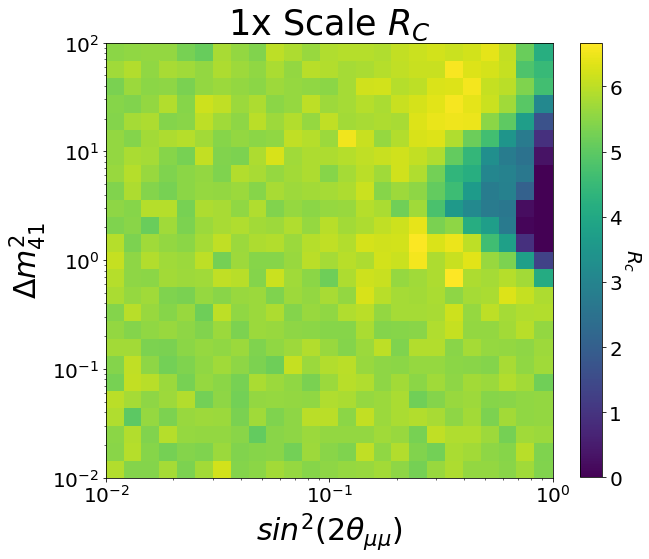

In [8]:
# make sensitivity plots
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)
# y,x = np.meshgrid(m41_list, sin22theta_list[0:24])

#convert intensity (list of lists) to a numpy array for plotting
intensity_90 = np.array(chi_c_array_90)
critchi_filename=""
if statsOnly:
    critchi_filename="ub_numudis_rterm_shaperate_freq_1x_statsonly.txt"
else:    
    critchi_filename="ub_numudis_rterm_shaperate_freq_1x.txt"
np.savetxt("/home/jmills/workdir/Disappearance/newLimits/"+critchi_filename,intensity_90)

# intensity_90 = intensity_90[0:24,:]
print(x.shape, y.shape, intensity_90.shape)
# print(intensity)

#now just plug the data into pcolormesh
# plt.pcolormesh(x, y, intensity_90,norm=colors.LogNorm(vmin=intensity_90.min(), vmax=intensity_90.max()))
plt.pcolormesh(x, y, intensity_90)
cbar = plt.colorbar()
# cbar.set_label(r'$ \chi^2_c$',rotation=0,fontsize=20)
cbar.set_label(r'$ R_c$',rotation=270,fontsize=20,labelpad=20)

# plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)
# plt.title(r'$\chi^2_C$ for 90% CL',fontsize=35)
if not statsOnly:
#     plt.title(r'$R_C$ for 90% CL',fontsize=35)
    plt.title(r'1x Scale $R_C$',fontsize=35)

else:
    plt.title(r'Stats-Only $R_C$',fontsize=35)
plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
# plt.savefig('CLplot_statonly_90CL_211117.png')
plt.show()

In [9]:
# for colsCutMin in range(0,9):
#     print(colsCutMin)
#     # make sensitivity plots
#     import matplotlib.colors as colors
#     fig,ax = plt.subplots(figsize=(10,8))
#     y,x = np.meshgrid(m41_list, sin22theta_list)
#     # y,x = np.meshgrid(m41_list, sin22theta_list[0:24])

#     #convert intensity (list of lists) to a numpy array for plotting
#     intensity_90 = np.array(chi_c_array_90)
#     critchi_filename = "ub_numudis_critchi2_shaperate_freq.txt"
#     if do1x:
#         critchi_filename="ub_numudis_critchi2_shaperate_freq_1x.txt"
#     np.savetxt("/home/jmills/workdir/Disappearance/newLimits/"+critchi_filename,intensity_90)

#     # intensity_90 = intensity_90[0:24,:]
#     print(x.shape, y.shape, intensity_90.shape)
#     # print(intensity)

#     #now just plug the data into pcolormesh
#     # plt.pcolormesh(x, y, intensity_90,norm=colors.LogNorm(vmin=intensity_90.min(), vmax=intensity_90.max()))

#     if colsCutMin != 0:
#         intensity_90[-colsCutMin:,:] = 0

#     plt.pcolormesh(x, y, intensity_90)
#     # plt.pcolormesh(x[0:colsCut,:], y[0:colsCut,:], intensity_90[0:colsCut,:])

#     cbar = plt.colorbar()
#     cbar.set_label(r'$ \chi^2_c$',rotation=0,fontsize=20)

#     # plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)
#     plt.title(r'$\chi^2_C$ for 90% CL',fontsize=35)
#     plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
#     plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
#     plt.xscale("log")
#     plt.yscale("log")
#     plt.savefig("/home/jmills/workdir/Disappearance/newLimits/slicer/critchi_slice_"+str(colsCutMin)+".png")
#     plt.show()

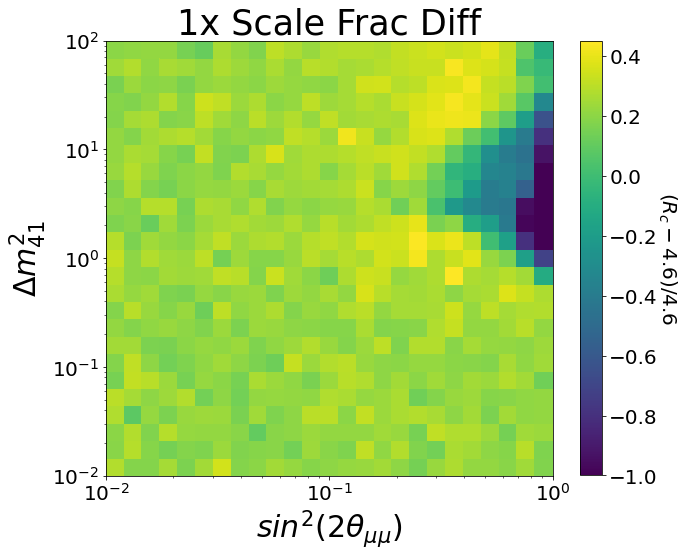

In [10]:

fig,ax = plt.subplots(figsize=(10,8))

#convert intensity (list of lists) to a numpy array for plotting
fracintensity_90 = (intensity_90-4.6)/(4.6)
# print(intensity)

#now just plug the data into pcolormesh
plt.pcolormesh(x, y, fracintensity_90)
# plt.pcolormesh(x, y, intensity_90)
cbar = plt.colorbar()
cbar.set_label(r'$ (R_c - 4.6)/4.6$',rotation=270,fontsize=20,labelpad=20)

# plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)
if not statsOnly:
#     plt.title(r'Frac Diff from 2DoF 90% CL',fontsize=35)
    plt.title(r'1x Scale Frac Diff',fontsize=35)

else:
    plt.title(r'Stats-Only Frac Diff',fontsize=35)
plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
# plt.savefig('CLplot_statonly_fracdiff2dof_90CL_211117.png')
plt.show()

In [11]:
# for colsCutMin in range(0,9):

#     fig,ax = plt.subplots(figsize=(10,8))

#     #convert intensity (list of lists) to a numpy array for plotting
#     if colsCutMin != 0:
#         intensity_90[-colsCutMin:,:] = 4.6
#     fracintensity_90 = (intensity_90-4.6)/(4.6)
#     # print(intensity)

#     #now just plug the data into pcolormesh
#     plt.pcolormesh(x, y, fracintensity_90)
#     # plt.pcolormesh(x, y, intensity_90)
#     cbar = plt.colorbar()
#     cbar.set_label(r'$ (\chi^2_c - 4.6)/4.6$',rotation=0,fontsize=20,labelpad=40)

#     # plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)

#     plt.title(r'Frac Diff from 2DoF 90% CL',fontsize=35)
#     plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
#     plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
#     plt.xscale("log")
#     plt.yscale("log")
#     plt.savefig("/home/jmills/workdir/Disappearance/newLimits/slicer/critchi_frac_slice_"+str(colsCutMin)+".png")
#     plt.show()

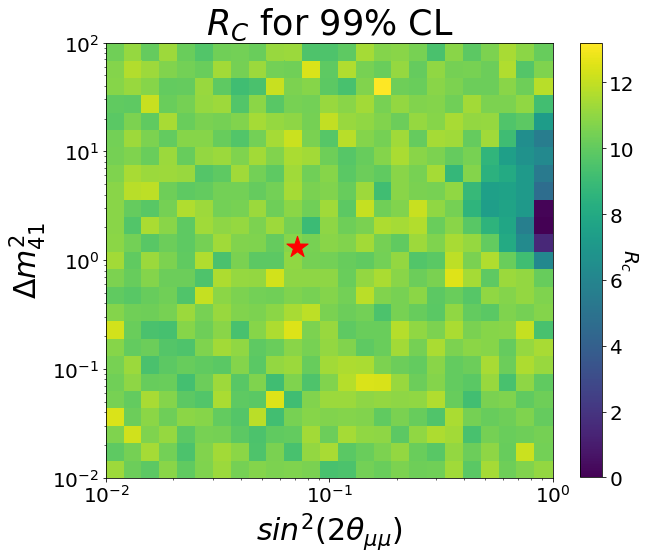

In [12]:
# make sensitivity plots
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)

#convert intensity (list of lists) to a numpy array for plotting
intensity_99 = np.array(chi_c_array_99)
# print(intensity)

#now just plug the data into pcolormesh
# plt.pcolormesh(x, y, intensity_99,norm=colors.LogNorm(vmin=intensity_99.min(), vmax=intensity_99.max()))
plt.pcolormesh(x, y, intensity_99)

cbar = plt.colorbar()
cbar.set_label(r'$ R_c$',rotation=270,fontsize=20)

plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)

plt.title(r'$R_C$ for 99% CL',fontsize=35)
plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_99CL_211117.png')
plt.show()

(25, 25)
625
26
(26, 26) (26, 26) (25, 25)
1141.2
(25, 25) (25, 25) (25, 25) shapes
(28, 2)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:64: UserWarning: The following kwargs were not used by contour: 'fontsize'


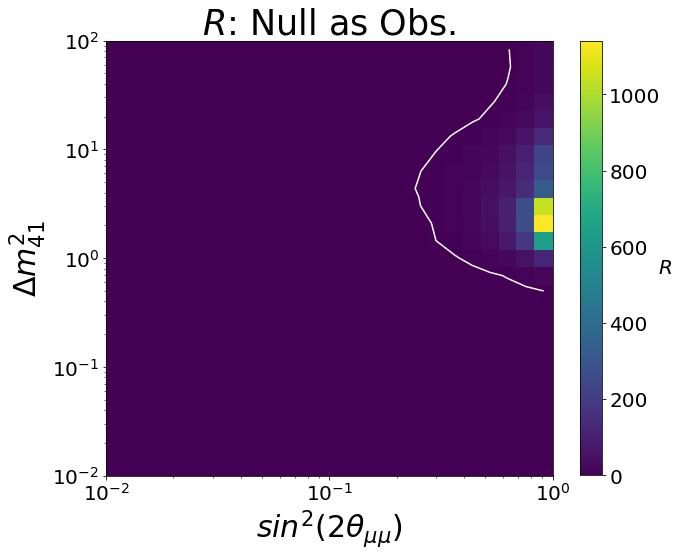

In [13]:
# Non-Frequentist Sensitivity

# chi2 array is more complicated
# each row represents a grid point
# first load as list of lists and make 1D plots

# Load in sensitivity chi2s
# initialize arr to fill
bins = 25
chi2_sens_arr=[]
nonFreqFileName = ""
if statsOnly:
    nonFreqFileName = "rterms_statsonly_1x_nonfreq_shaperate.txt"
else:
    nonFreqFileName = "rterms_1x_nonfreq_shaperate.txt"
with open(nonFreqFileName,"r") as chis_sens:
    lines = chis_sens.readlines()
    for line in lines:
        vals = line.split(" ")
        chi2_sens_arr.append(float(vals[0]))
# change to 2d lists
print((len(m41_list)-1,len(sin22theta_list)-1))
print(len(chi2_sens_arr))
chi_sens_array =np.zeros((len(m41_list)-1,len(m41_list)-1))
for pt in range(len(chi2_sens_arr)):
    s_id = pt % (len(sin22theta_list)-1)
    m_id = math.floor(pt/(len(m41_list)-1))
    try:
        chi_sens_array[s_id][m_id]=chi2_sens_arr[pt]
    except:
        print(s_id, m_id)
        chi_sens_array[s_id][m_id]=chi2_sens_arr[pt]

    
# chi_sens_array[chi_sens_array >4.6] = 7
# chi_sens_array[chi_sens_array>50] = 50
# chi_sens_array[chi_sens_array<=0.1] = 0.1
# chi_sens_array[chi_sens_array<=0] = 0

      
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
print(len(m41_list))
y,x = np.meshgrid(m41_list, sin22theta_list)
#now just plug the data into pcolormesh
# plt.pcolormesh(x, y, chi_sens_array,norm=colors.LogNorm(vmin=chi_sens_array.min(), vmax=chi_sens_array.max()))
plt.pcolormesh(x, y, chi_sens_array)
print(x.shape,y.shape,chi_sens_array.shape)

print(np.max(chi_sens_array))

cbar = plt.colorbar()
cbar.set_label(r'$ R$',rotation=0,fontsize=20)

xmod = x[0:-1,0:-1]
ymod = y[0:-1,0:-1]
for i in range(xmod.shape[0]):
    for j in range(xmod.shape[1]):
        xmod[i,j] = np.sqrt(x[i,j]*x[i+1,j+1])
        ymod[i,j] = np.sqrt(y[i,j]*y[i+1,j+1])
        
print(xmod.shape,ymod.shape, chi_sens_array.shape, "shapes")

contours = plt.contour(xmod, ymod, chi_sens_array,[4.6], colors='white',fontsize=20);
for item in contours.collections:
    for i in item.get_paths():
        v = i.vertices
        shape_only_90_xs = v[:, 0]
        shape_only_90_ys = v[:, 1]
        print(v.shape)
        outNonFreqLimFileName = ""
        if statsOnly:
            outNonFreqLimFileName = "ub_shaperate_numudis_nonfreq_sens90_1x_statsonly.txt"
        else:
            outNonFreqLimFileName = "ub_shaperate_numudis_nonfreq_sens90_1x.txt"
        np.savetxt("/home/jmills/workdir/Disappearance/newLimits/"+outNonFreqLimFileName,v)

# plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)
plt.title(r'$R$: Null as Obs.',fontsize=35)
# plt.title(r'$R$: Null as Obs. Log Scale',fontsize=35)
plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
# plt.savefig('CLplot_statonly_90CL_211117.png')
plt.show()
        


(26, 26) (26, 26) (25, 25)
1141.2
0.0
(26, 26) (26, 26) (25, 25)
(18, 2)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: UserWarning: No contour levels were found within the data range.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:53: UserWarning: The following kwargs were not used by contour: 'fontsize'


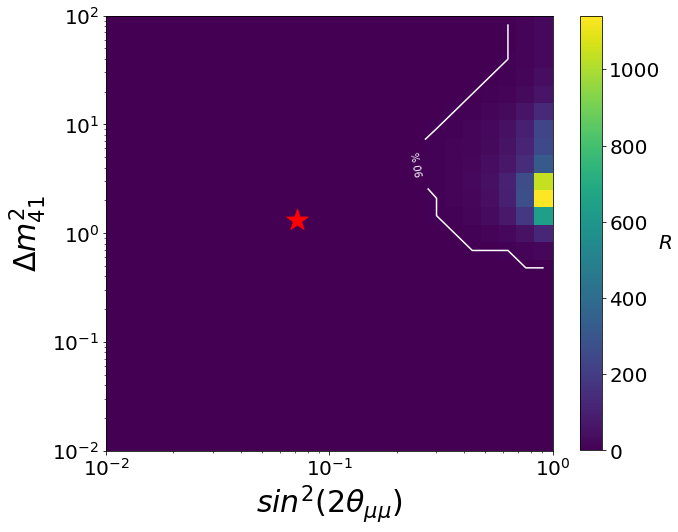

In [14]:
# get contour levels 0 = 90% CL, 1 = 99% CL, 2 = other
# deltachi < chi_c_90 for 90%, <chi_c_99 for 99%  
usedata=False
confidence_arr = np.zeros((bins,bins))
deltachi_arr = np.zeros((bins,bins))
for s in range(len(chi_sens_array)):
    for m in range(len(chi_sens_array[s])):
            if usedata==False: nullchi=0
            else: nullchi = bestchi
#             if chi_sens_array[s][m] < 0:
#                 print(s,m, chi_sens_array[s][m])
            delta = chi_sens_array[s][m] - nullchi
            deltachi_arr[s][m] = abs(delta)
            chi2_c_90_this = intensity_90[s,m]
            chi2_c_99_this = intensity_99[s,m]
            if delta == 0: deltachi_arr[s][m] = .000001
            if delta < chi2_c_90_this:
                confidence_arr[s][m] = confidence_limit
            else:
                confidence_arr[s][m] = 1 
#                 print(s,m)
#                 print(delta)
#                 print(chi2_c_90_this)
#                 assert 1==2
# make CL plots
#setup the 2D grid with Numpy
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(chi_sens_array)
print(x.shape,y.shape,intensity.shape)
print(np.max(intensity))
print(np.min(intensity))
# print(intensity)

#now just plug the data into pcolormesh
# plt.pcolormesh(x, y, intensity,norm=colors.LogNorm(vmin=intensity.min(), vmax=intensity.max()))
plt.pcolormesh(x, y, intensity) 
cbar = plt.colorbar()
cbar.set_label(r'$R$',rotation=0,fontsize=20)
#contour plots
print(x.shape,y.shape,confidence_arr.shape)
# assert 1==2
xmod = x[0:-1,0:-1]
ymod = y[0:-1,0:-1]
for i in range(xmod.shape[0]):
    for j in range(xmod.shape[1]):
        xmod[i,j] = np.sqrt(x[i,j]*x[i+1,j+1])
        ymod[i,j] = np.sqrt(y[i,j]*y[i+1,j+1])

contours = plt.contour(xmod, ymod, confidence_arr,[confidence_limit], colors='white',fontsize=20);
shape_only_90_xs = []
shape_only_90_ys = []
for item in contours.collections:
    for i in item.get_paths():
        v = i.vertices
        shape_only_90_xs = v[:, 0]
        shape_only_90_ys = v[:, 1]
        print(v.shape)
        outFreqLimFileName = ""
        if statsOnly:
            outFreqLimFileName = "ub_shaperate_numudis_sens90_1x_statsonly.txt"
        else:
            outFreqLimFileName = "ub_shaperate_numudis_sens90_1x.txt"
        np.savetxt("/home/jmills/workdir/Disappearance/newLimits/"+outFreqLimFileName,v)
def fmt(x):
    s = f"{x*100:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

label1 = plt.clabel(contours, contours.levels,  fmt=fmt, fontsize=10,rightside_up=False)

plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)
# plt.scatter([xmod[18,19]],[ymod[18,19]],color = 'black',marker='*',s=500)
# plt.scatter([xmod[0,0]],[ymod[0,0]],color = 'black',marker='*',s=500)

plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_210901.png')
plt.show()            
# print(confidence_arr)
                

In [15]:
# # load in old chi2 to compare
# # read in grid search file info here
# # this is complicated since the writing was simplistic
# bins = 25
# shapeonly = False
# usedata= False
# with open("gridsearch_MCsens_allosc_original.txt","r") as gridsearch:
#     lines = gridsearch.readlines()
#     m41_list =[]
#     sin22theta_list=[]
#     chi2_list = np.zeros((bins,bins))

#     for v in range(bins):
#         vals = lines[v].strip()
#         m41_list.append(float(lines[v].strip()))
#         sin22theta_list.append(float(lines[v+bins].strip()))
#         for j in range(bins):
#             chi2_list[j][v]=float(lines[v+2*bins+j*bins].strip())
   
#     bestm = float(lines[-3].strip())
#     bests = float(lines[-2].strip())
#     bestchi = float(lines[-1].strip())
    
# if False:
# #     print(m41_list,len(m41_list))
# #     print(sin22theta_list, len(sin22theta_list))
#     print(chi2_list, len(chi2_list),len(chi2_list[0]))
#     print(np.where(chi2_list<0,1,0))
# #     print(bestm)
# #     print(bests)
# #     print(bestchi)

In [16]:
# get contour levels 0 = 90% CL, 1 = 99% CL, 2 = other
# deltachi < 4.6 for 90%, <9.2 for 99%  https://people.richland.edu/james/lecture/m170/tbl-chi.html
confidence_arr = np.zeros((bins,bins))
deltachi_arr = np.zeros((bins,bins))
for s in range(len(chi2_list)):
    for m in range(len(chi2_list[s])):
            if usedata==False: nullchi=0
            else: nullchi = bestchi
            if chi2_list[s][m] < 0:
                print(s,m, chi2_list[s][m])
            delta = chi2_list[s][m] - nullchi
            deltachi_arr[s][m] = abs(delta)
            if delta == 0: deltachi_arr[s][m] = .000001
            if delta < 4.6: 
                confidence_arr[s][m] = confidence_limit
            else:
                confidence_arr[s][m] = 1 

NameError: name 'chi2_list' is not defined

In [ ]:
# make CL plots
#setup the 2D grid with Numpy
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)
#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(chi2_list)
print(np.min(intensity))
# print(intensity)

#now just plug the data into pcolormesh
# plt.pcolormesh(x, y, intensity,norm=colors.LogNorm(vmin=intensity.min(), vmax=intensity.max()))
plt.pcolormesh(x, y, intensity)
cbar = plt.colorbar()
cbar.set_label(r'$Total \chi^2$',rotation=0,fontsize=20)
#contour plots
contours = plt.contour(x, y, confidence_arr,[confidence_limit], colors='white',fontsize=20);

def fmt(x):
    s = f"{x*100:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

label1 = plt.clabel(contours, contours.levels,  fmt=fmt, fontsize=10,rightside_up=False)

plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)

plt.xlabel(r"$sin^2$(2$\theta_{\mu \mu}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_210901.png')
plt.show()

In [ ]:
# subtract one from the other
confidence_arr_delta = np.zeros((bins,bins))
for s in range(len(chi2_list)):
    for m in range(len(chi2_list[s])):
            critchi = intensity_90[s][m]
            delta=chi2_list[s][m]
            if delta < critchi:
                confidence_arr_delta[s][m] = confidence_limit
            else:
                confidence_arr_delta[s][m] = 1 

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
plt.pcolormesh(x, y, intensity,norm=colors.LogNorm(vmin=intensity.min(), vmax=intensity.max()))
# plt.pcolormesh(x, y, deltachi)
cbar = plt.colorbar()
cbar.set_label(r'$\Delta \chi^2$',rotation=0,fontsize=20)
#contour plots
contours = plt.contour(x, y, confidence_arr,[confidence_limit], colors='white',fontsize=20);
contours_new = plt.contour(x, y, confidence_arr_delta,[confidence_limit], colors='red',fontsize=20);

def fmt(x):
    s = f"{x*100:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

# label1 = plt.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=False)
# label2 = plt.clabel(contours_new, contours_new.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=False)

plt.scatter([0.071571],[1.32],color = 'red',marker='*',s=500)

plt.xlabel(r"$sin^2$(2$\theta_{\mu e}$)",fontsize=30)
plt.ylabel(r"$\Delta m^2_{41}$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_210901.png')
plt.show()

print("best m:",bestm)
print("best s:",bests)
print(bestchi)
